# Matrix Bubbling

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# This file contains all the main external libs we'll use
# We'll assume you already have numpy and opencv installed
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utility Functions
def draw_with_size(image, size_in_inches):
    plt.figure(figsize=(size_in_inches, size_in_inches))
    plt.imshow(image);
    
def random_image(shape):
    return np.random.uniform(0, 1, size=shape).astype(np.float32)

def scale_match(src, targ):
    """Returns the targ image resized so that its at exactly as big as src, while maintaining its aspect ratio.
    This may mean that the right or the bottom may be cropped."""
    h,w,_ = src.shape
    sh,sw,_ = targ.shape
    ratio = max(h/sh,w/sw);
    res = cv2.resize(targ, (int(sw*ratio), int(sh*ratio)))
    return res[:h,:w]

## Some Morphological Operations

Morphological operations apply a structuring element to an input image, creating an output image of the same size. In a morphological operation, the value of each pixel in the output image is based on a comparison of the corresponding pixel in the input image with its neighbors. By choosing the size and shape of the neighborhood, you can construct a morphological operation that is sensitive to specific shapes in the input image.

We'll use the following morphological operations to try to mimick real life transformations to images.

### Dilation and Erosion

Dilation adds pixels to the boundaries of objects in an image, while erosion removes pixels on object boundaries. The number of pixels added or removed from the objects in an image depends on the size and shape of the structuring element used to process the image. In the morphological dilation and erosion operations, the state of any given pixel in the output image is determined by applying a rule to the corresponding pixel and its neighbors in the input image. The rule used to process the pixels defines the operation as a dilation or an erosion. 
Reference - https://www.mathworks.com/help/images/morphological-dilation-and-erosion.html

* 
Dilation - The value of the output pixel is the maximum value of all the pixels in the input pixel's neighborhood. In a binary image, if any of the pixels is set to the value 1, the output pixel is set to 1.

* 
Erosion - The value of the output pixel is the minimum value of all the pixels in the input pixel's neighborhood. In a binary image, if any of the pixels is set to 0, the output pixel is set to 0.

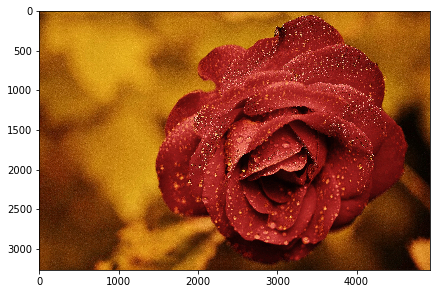

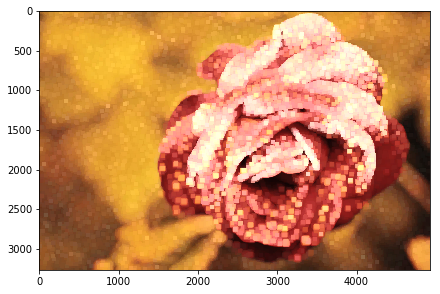

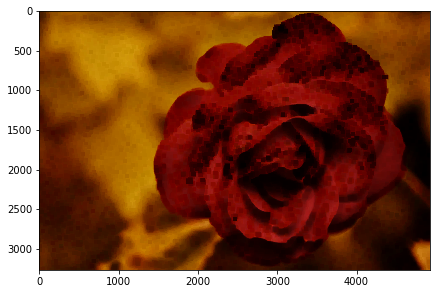

In [2]:
# Flower Image
img = cv2.imread('samples/flower.jpg',-1)
draw_with_size(img, 7)
kernel = np.ones((50,50),np.uint8)

# Dilation
dilation = cv2.dilate(img,kernel,iterations = 1)
draw_with_size(dilation, 7)

# Erosion
erosion = cv2.erode(img,kernel,iterations = 1)
draw_with_size(erosion, 7)

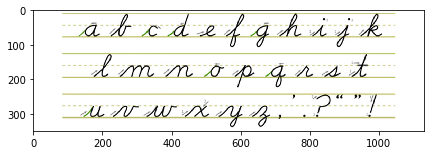

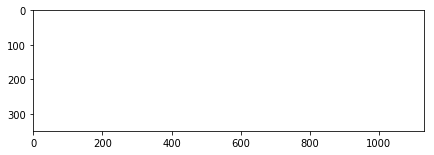

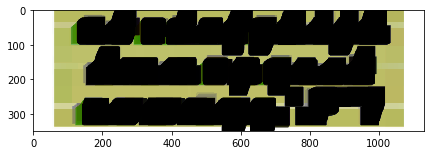

In [3]:
# Flower Image
img = cv2.imread('samples/Writing.jpg',1)
draw_with_size(img, 7)
kernel = np.ones((50,50),np.uint8)
dilation = cv2.dilate(img,kernel,iterations = 1)
draw_with_size(dilation, 7)
erosion = cv2.erode(img,kernel,iterations = 1)
draw_with_size(erosion, 7)

### Adding Random Noise

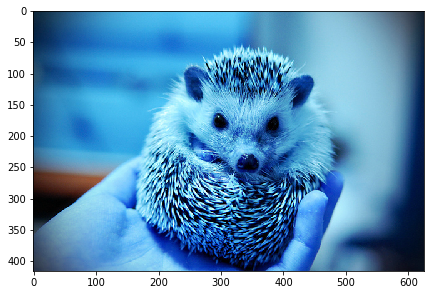

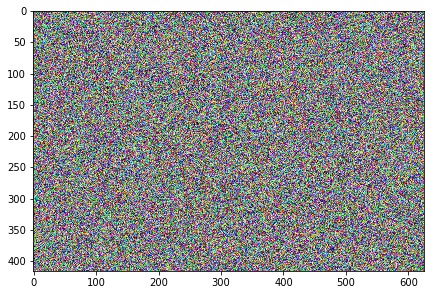

In [4]:
# Gaussian Noise
image = cv2.imread('samples/small-animal.jpg',-1)
draw_with_size(image, 7)
row,col,ch= image.shape
mean = 0.0
var = 0.01
sigma = var**0.5
gauss = np.array(image.shape)
gauss = np.random.normal(mean,sigma,(row,col,ch))
gauss = gauss.reshape(row,col,ch)
noisy = image + 1000*gauss
draw_with_size(noisy, 7)

This function computes the distance between two matrices `A` and `B` and returns a score. Here, `n` is a parameter that specifies how many cuts to make along each axis.

In [38]:
def computeDistance(A, B, n, metric):
    row, col = A.shape
    # trim matrix so grids are all the same size
    row -= row % n
    col -= col % n
    dist = 0
    for i in range(row // n):
        for j in range(col // n):
            # gridA = A[n*i:n*i+n][n*j:n*j+n]
            gridA = A[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            gridB = B[np.ix_(range(n*i,n*i+n), range(n*j,n*j+n))]
            meanA, covA = getSummary(gridA)
            # print(covA)
            meanB, covB = getSummary(gridB)
            # print(covB)
            dist += getDist(meanA, covA, meanB, covB, metric)
    return dist

def getSummary(grid):
    # get points in grid as an array
    x = []
    y = []
    row, col = grid.shape
    # print(grid.shape)
    # print(row, col)
    for i in range(row):
        for j in range(col):
            # print(i, j, grid[i][j])
            if grid[i][j] > 0:
                for k in range(grid[i][j]):
                    x.append(i)
                    y.append(j)
    x = np.array(x)
    y = np.array(y)
    # print(x)
    # print(y)
    xMean = np.mean(x)
    yMean = np.mean(y)
    mean = np.array([xMean, yMean])
    x = x - xMean
    y = y - yMean
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    return (mean.T, cov)

def getDist(meanA, covA, meanB, covB, metric):
    '''Pick which distance metric to use'''
    if metric == "KL":
        return getKLDiv(meanA, covA, meanB, covB)
    if metric == "Hell":
        return getHellDist(meanA, covA, meanB, covB)
    else:
        raise ValueError()

def getKLDiv(meanA, covA, meanB, covB):
    '''A represents the actual distribution and B represents the test distribution'''
    mu = meanB - meanA
    return 0.5 * (np.log(np.linalg.det(covB) / np.linalg.det(covA)) \
                  + mu.T @ np.linalg.inv(covB) @ mu \
                  + np.trace(covA @ np.linalg.inv(covB)) \
                  - 2)

def getHellDist(meanA, covA, meanB, covB):
    mu = meanA - meanB
    return 1 \
           - np.power(np.linalg.det(covA), 0.25) \
           * np.power(np.linalg.det(covA), 0.25) \
           / np.power(np.linalg.det((covA+covB)/2), 0.5) \
           * np.exp(-0.125 * mu.T @ np.linalg.inv((covA+covB)/2) @ mu)

In [45]:
test1 = np.array([[1, 2, 3],
                  [4, 5, 6],
                  [5, 6, 7],
                  [5, 7, 8],
                  [7, 8, 9]])

test2 = np.array([[0, 5, 3],
                  [6, 7, 0],
                  [5, 6, 10],
                  [9, 0, 8],
                  [7, 9, 0]])

# computeDistance()
for metric in ["Hell", "KL"]:
    for (A, B) in [(test1, test1), (test1, test2), (test2, test1), (test2, test2)]:
        a = "test1" if np.array_equal(A, test1) else "test2"
        b = "test1" if np.array_equal(B, test1) else "test2"
        print("A: " + a)
        print("B: " + b)
        print("metric: " + str(metric))
        try:
            print(computeDistance(A, B, 2, metric))
            print()
        except:
            print("Error")
            print()
    print("-----------------------")

A: test1
B: test1
metric: Hell
-2.220446049250313e-16

A: test1
B: test2
metric: Hell
-0.07331881068759749

A: test2
B: test1
metric: Hell
0.3250000527639908

A: test2
B: test2
metric: Hell
1.1102230246251565e-16

-----------------------
A: test1
B: test1
metric: KL
0.0

A: test1
B: test2
metric: KL
0.8555809969604238

A: test2
B: test1
metric: KL
0.4747618682808803

A: test2
B: test2
metric: KL
0.0

-----------------------
